# Visualizing On- and Off-Target Morphological Signatures

This notebook evaluates whether our morphological signatures effectively capture phenotypic differences. We apply PCA and UMAP to reduce the feature space to two dimensions and visualize the distribution of DMSO (negative control) and TGFRi (positive control) treated cells at the single-cell level.

In [1]:
# Load required libraries
suppressPackageStartupMessages({
    library(tidyverse)
    library(arrow)
    library(jsonlite)
    library(ggplot2)
    library(patchwork)
    library(scales)
    library(umap)
})


Setting global configurations for plotting

In [2]:
# Set random seed for reproducibility
set.seed(0)

# ggplot configuration
theme_set(
    theme_minimal(base_size = 12, base_family = "sans") +
    theme(
        # Axis styling
        axis.line = element_line(color = "black", linewidth = 0.5),
        axis.ticks = element_line(color = "black", linewidth = 0.5),
        axis.text = element_text(color = "black", size = 10),
        axis.title = element_text(face = "bold", size = 11),
        
        # Panel styling
        panel.grid.major = element_line(color = "grey90", linewidth = 0.25),
        panel.grid.minor = element_blank(),
        panel.background = element_rect(fill = "white", color = NA),
        panel.border = element_blank(),
        
        # Plot styling
        plot.title = element_text(face = "bold", size = 13, hjust = 0.5),
        plot.subtitle = element_text(size = 10, hjust = 0.5, color = "grey40"),
        plot.background = element_rect(fill = "white", color = NA),
        
        # Legend styling
        legend.position = "right",
        legend.title = element_text(face = "bold", size = 10),
        legend.text = element_text(size = 9),
        legend.background = element_rect(fill = "white", color = "grey80", linewidth = 0.3),
        legend.key = element_blank(),
        
        # Strip styling for facets
        strip.text = element_text(face = "bold", size = 11),
        strip.background = element_rect(fill = "grey95", color = "grey80")
    )
)

# color pallete 
color_palette <- c(
    "DMSO" = "#66c2a5",
    "TGFRi" = "#fc8d62"
)

Setting up Input and Output Paths

In [3]:
# Define directory paths
module_results_dir <- file.path("..", "results")
figures_dir <- file.path(".", "figures")

# Input paths for pre-computed PCA and UMAP results
pca_dir <- file.path(module_results_dir, "pca")
umap_dir <- file.path(module_results_dir, "umap")

# PCA file paths
pca_on_path <- file.path(pca_dir, "cfret_pilot_on_morph_pca.parquet")
pca_off_path <- file.path(pca_dir, "cfret_pilot_off_morph_pca.parquet")

# UMAP file paths
umap_on_path <- file.path(umap_dir, "cfret_pilot_on_morph_umap.parquet")
umap_off_path <- file.path(umap_dir, "cfret_pilot_off_morph_umap.parquet")

# Verify files exist
if (!file.exists(pca_on_path)) stop("PCA on-target file not found")
if (!file.exists(pca_off_path)) stop("PCA off-target file not found")
if (!file.exists(umap_on_path)) stop("UMAP on-target file not found")
if (!file.exists(umap_off_path)) stop("UMAP off-target file not found")

In [4]:
# Create figures directory
dir.create(figures_dir, showWarnings = FALSE, recursive = TRUE)

cat("Figures directory created at:", figures_dir, "\n")

Figures directory created at: ./figures 


Load PCA embeddings

In [5]:
# Load PCA results
pca_on_df <- read_parquet(pca_on_path)
pca_off_df <- read_parquet(pca_off_path)

# Display structure
cat("PCA ON shape:", nrow(pca_on_df), "×", ncol(pca_on_df), "\n")
cat("PCA OFF shape:", nrow(pca_off_df), "×", ncol(pca_off_df), "\n")

# Display cell counts by treatment
cell_counts_on <- pca_on_df %>%
    group_by(Metadata_treatment) %>%
    summarise(n_cells = n(), .groups = 'drop')

cat("\nCell counts by treatment:\n")
print(cell_counts_on)

# Verify required columns exist
required_cols <- c("PC1", "PC2", "Metadata_treatment")
if (!all(required_cols %in% names(pca_on_df))) {
    stop("Required columns missing in PCA data")
}

PCA ON shape: 15793 × 216 
PCA OFF shape: 15793 × 83 

Cell counts by treatment:
# A tibble: 2 × 2
  Metadata_treatment n_cells
  <chr>                <int>
1 DMSO                 10519
2 TGFRi                 5274


## Plotting PCA embeddings

Setting plot configurations

In [6]:
# Plot dimensions (in inches)
plot_width_combined <- 12
plot_height_combined <- 5.5
plot_width_faceted <- 10
plot_height_faceted <- 9

# Point styling
point_alpha <- 0.3
point_size <- 1.5
point_shape <- 16  # filled circle

# Faceted plot styling
facet_point_alpha <- 0.4
facet_point_size <- 1.2

# Legend styling
legend_alpha <- 1
legend_size <- 3

# Resolution for rendering
render_dpi <- 300

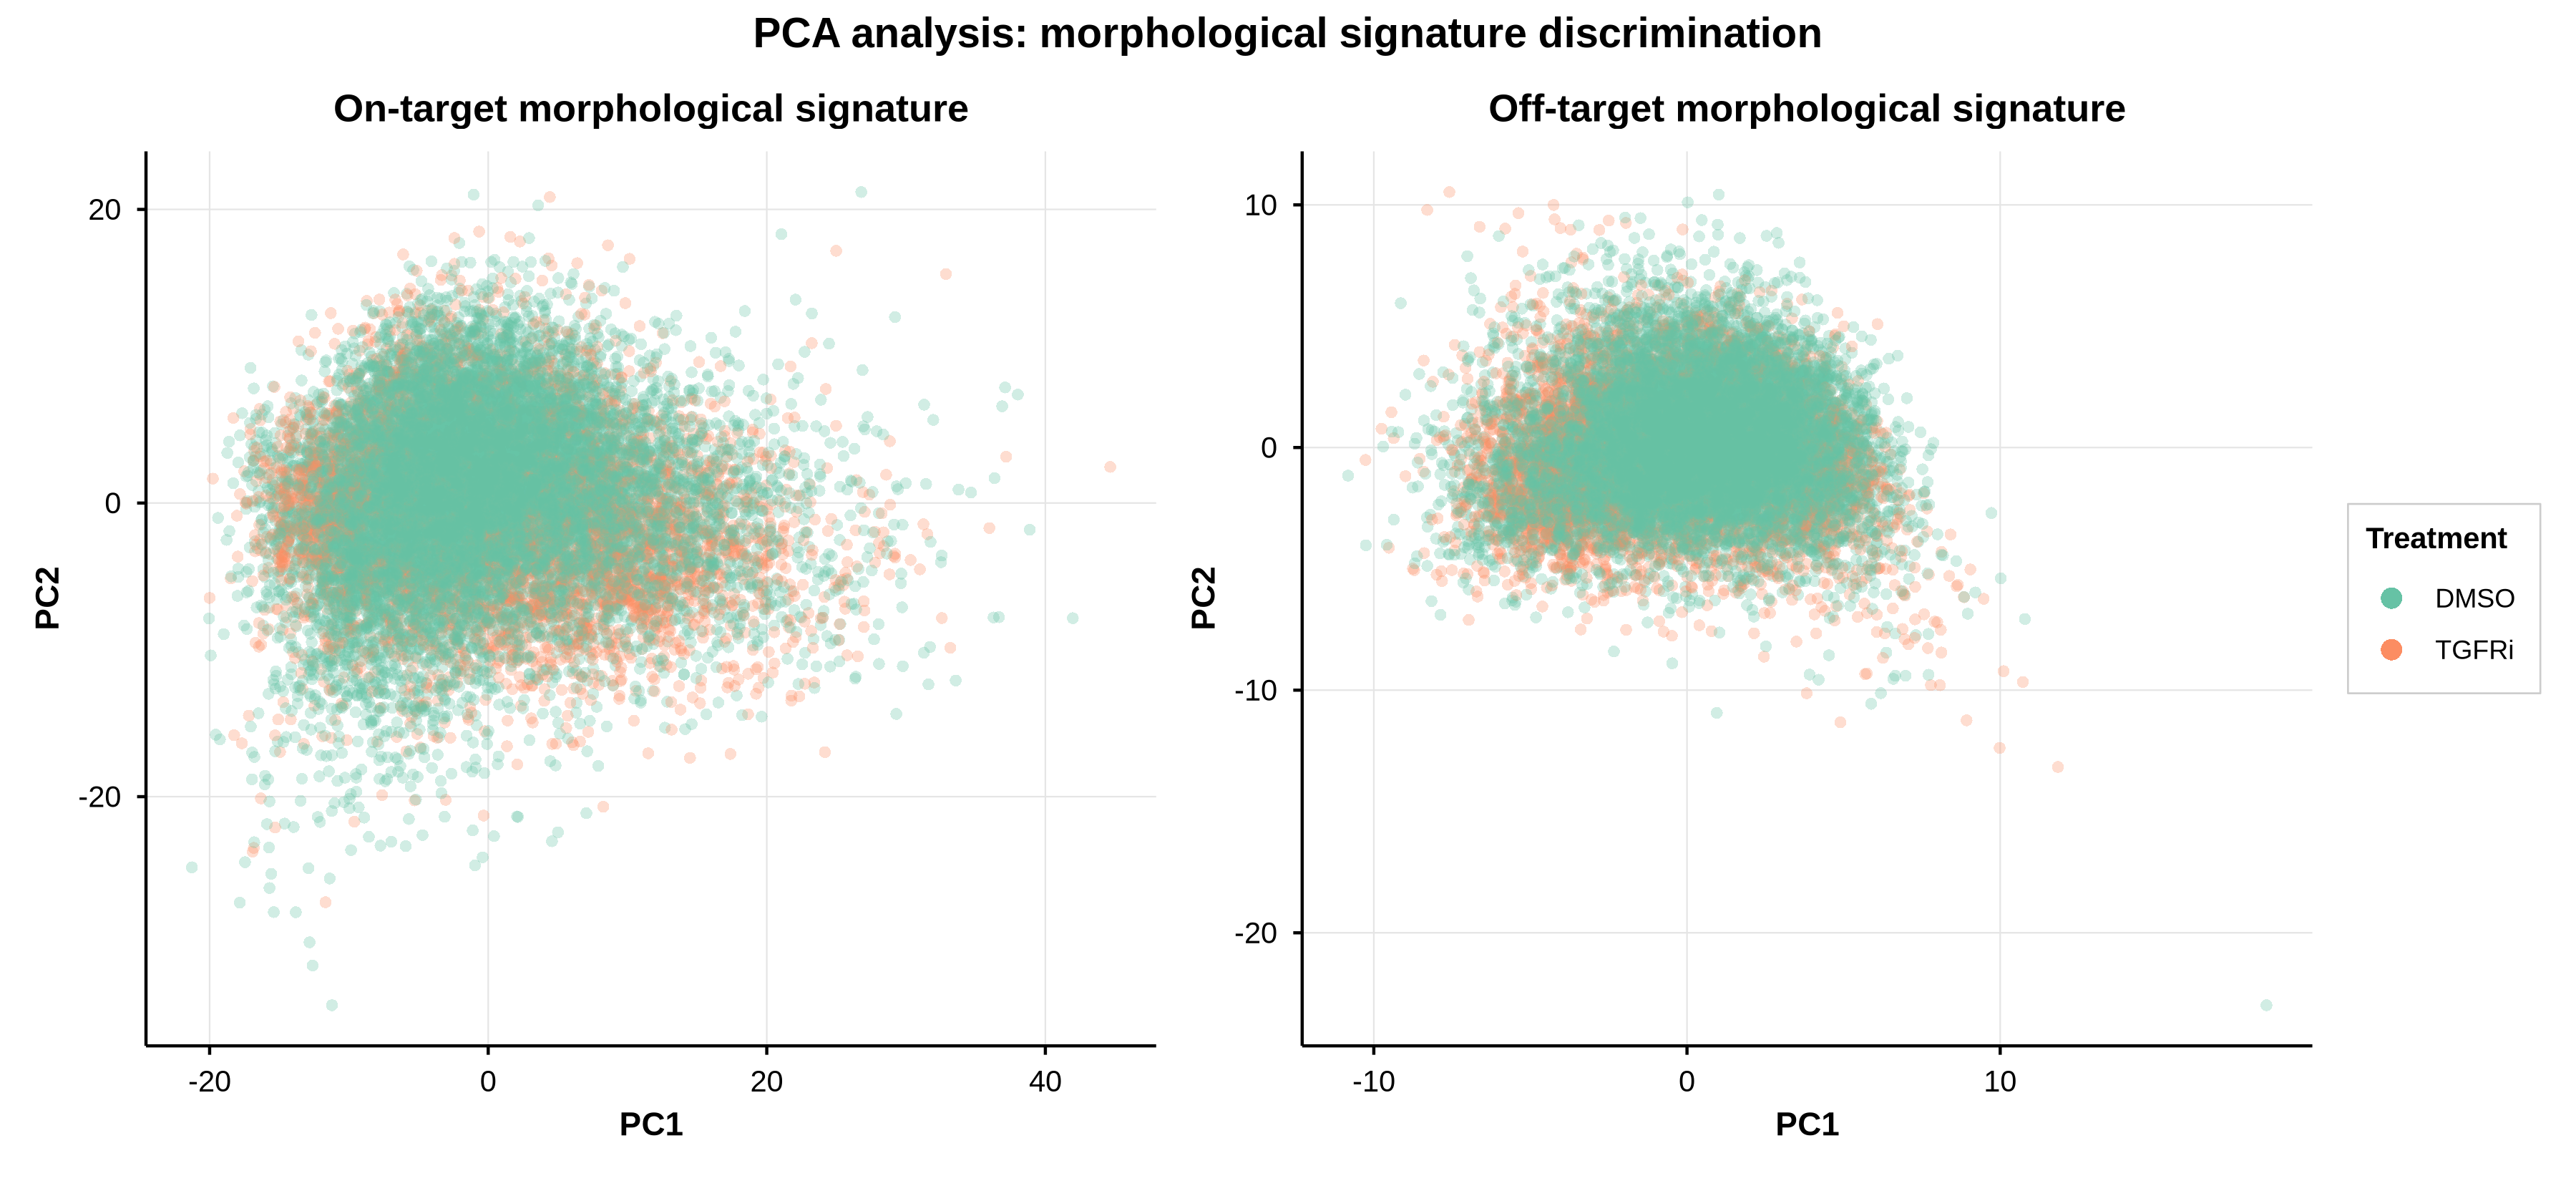

In [7]:
# Create on-target PCA plot
plot_pca_on <- ggplot(pca_on_df, aes(x = PC1, y = PC2, color = Metadata_treatment)) +
    geom_point(alpha = point_alpha, size = point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Treatment") +
    labs(
        title = "On-target morphological signature",
        x = "PC1",
        y = "PC2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size)))

# Create off-target PCA plot
plot_pca_off <- ggplot(pca_off_df, aes(x = PC1, y = PC2, color = Metadata_treatment)) +
    geom_point(alpha = point_alpha, size = point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Treatment") +
    labs(
        title = "Off-target morphological signature",
        x = "PC1",
        y = "PC2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size)))

# Combine plots using patchwork
pca_combined <- plot_pca_on + plot_pca_off +
    plot_layout(guides = "collect") +
    plot_annotation(
        title = "PCA analysis: morphological signature discrimination",
        theme = theme(plot.title = element_text(face = "bold", size = 14, hjust = 0.5))
    )

# Display plot
options(repr.plot.width = plot_width_combined, repr.plot.height = plot_height_combined, repr.plot.res = render_dpi)
print(pca_combined)

In [8]:
# Save PCA overlay comparison
ggsave(
    filename = file.path(figures_dir, "pca_on_off_comparison.png"),
    plot = pca_combined,
    width = plot_width_combined,
    height = plot_height_combined,
    dpi = render_dpi,
    bg = "white"
)

cat("Saved PCA overlay plots to:", figures_dir, "\n")

Saved PCA overlay plots to: ./figures 


### PCA visualization: faceted by treatment

Individual treatment groups displayed separately to examine within-group distributions.

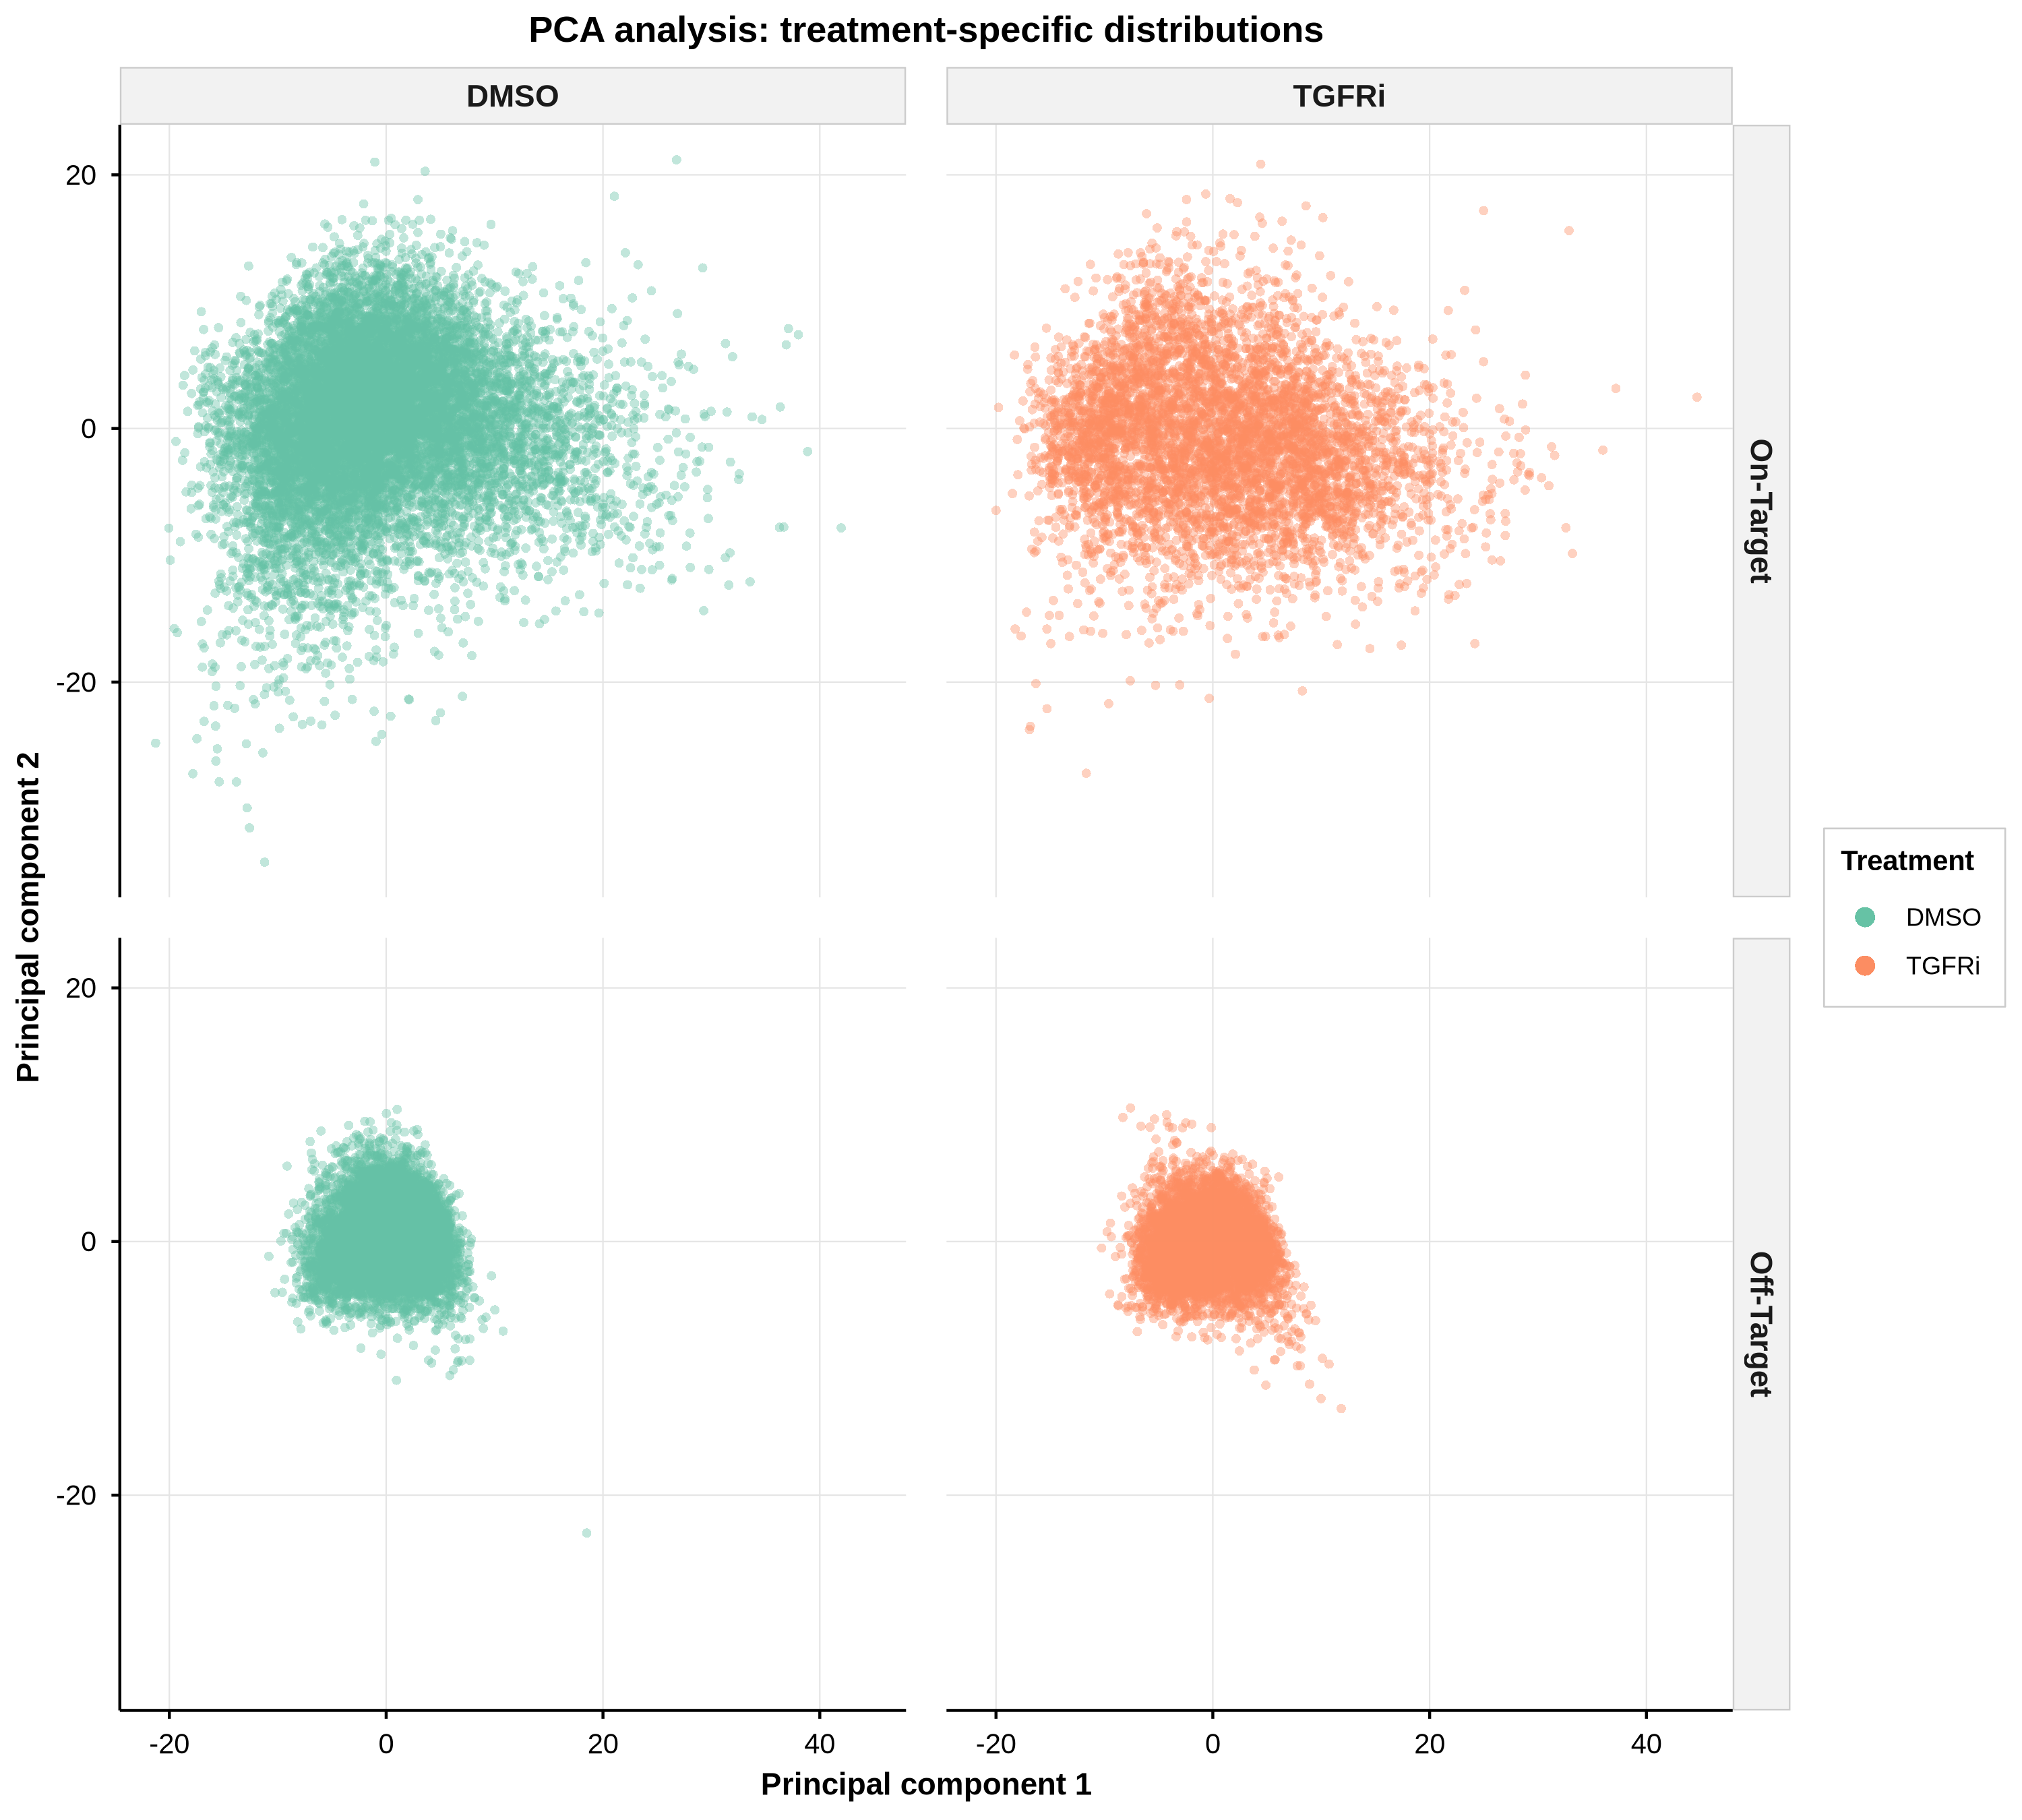

In [9]:
# Prepare data for faceting
pca_on_df_facet <- pca_on_df %>%
    mutate(signature_type = "On-Target")

pca_off_df_facet <- pca_off_df %>%
    mutate(signature_type = "Off-Target")

# Create faceted PCA plot
pca_faceted <- bind_rows(pca_on_df_facet, pca_off_df_facet) %>%
    mutate(
        signature_type = factor(signature_type, levels = c("On-Target", "Off-Target")),
        Metadata_treatment = factor(Metadata_treatment, levels = c("DMSO", "TGFRi"))
    ) %>%
    ggplot(aes(x = PC1, y = PC2, color = Metadata_treatment)) +
    geom_point(alpha = facet_point_alpha, size = facet_point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Treatment") +
    facet_grid(signature_type ~ Metadata_treatment) +
    labs(
        title = "PCA analysis: treatment-specific distributions",
        x = "Principal component 1",
        y = "Principal component 2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size))) +
    theme(
        strip.text = element_text(face = "bold", size = 11),
        panel.spacing = unit(1, "lines")
    )

# Display plot
options(repr.plot.width = plot_width_faceted, repr.plot.height = plot_height_faceted, repr.plot.res = render_dpi)
print(pca_faceted)

In [10]:
# Save PCA faceted plot
ggsave(
    filename = file.path(figures_dir, "pca_facet_grid.png"),
    plot = pca_faceted,
    width = plot_width_faceted,
    height = plot_height_faceted,
    dpi = render_dpi,
    bg = "white"
)

cat("Saved PCA faceted plots to:", figures_dir, "\n")

Saved PCA faceted plots to: ./figures 


## Plotting UMAP embeddings

Load UMAP embeddings

In [11]:
# Load pre-computed UMAP results
umap_on_df <- read_parquet(umap_on_path)
umap_off_df <- read_parquet(umap_off_path)

# Display structure
cat("UMAP ON shape:", nrow(umap_on_df), "×", ncol(umap_on_df), "\n")
cat("UMAP OFF shape:", nrow(umap_off_df), "×", ncol(umap_off_df), "\n")

# Display cell counts by treatment
cell_counts_umap <- umap_on_df %>%
    group_by(Metadata_treatment) %>%
    summarise(n_cells = n(), .groups = 'drop')

cat("\nCell counts by treatment:\n")
print(cell_counts_umap)

# Verify required columns exist
required_umap_cols <- c("UMAP1", "UMAP2", "Metadata_treatment")
if (!all(required_umap_cols %in% names(umap_on_df))) {
    stop("Required columns missing in UMAP data")
}

cat("\nUMAP data loaded successfully\n")

UMAP ON shape: 15793 × 22 
UMAP OFF shape: 15793 × 22 

Cell counts by treatment:
# A tibble: 2 × 2
  Metadata_treatment n_cells
  <chr>                <int>
1 DMSO                 10519
2 TGFRi                 5274

UMAP data loaded successfully


### UMAP visualization: overlay comparison

Side-by-side comparison of on-target and off-target UMAP projections.

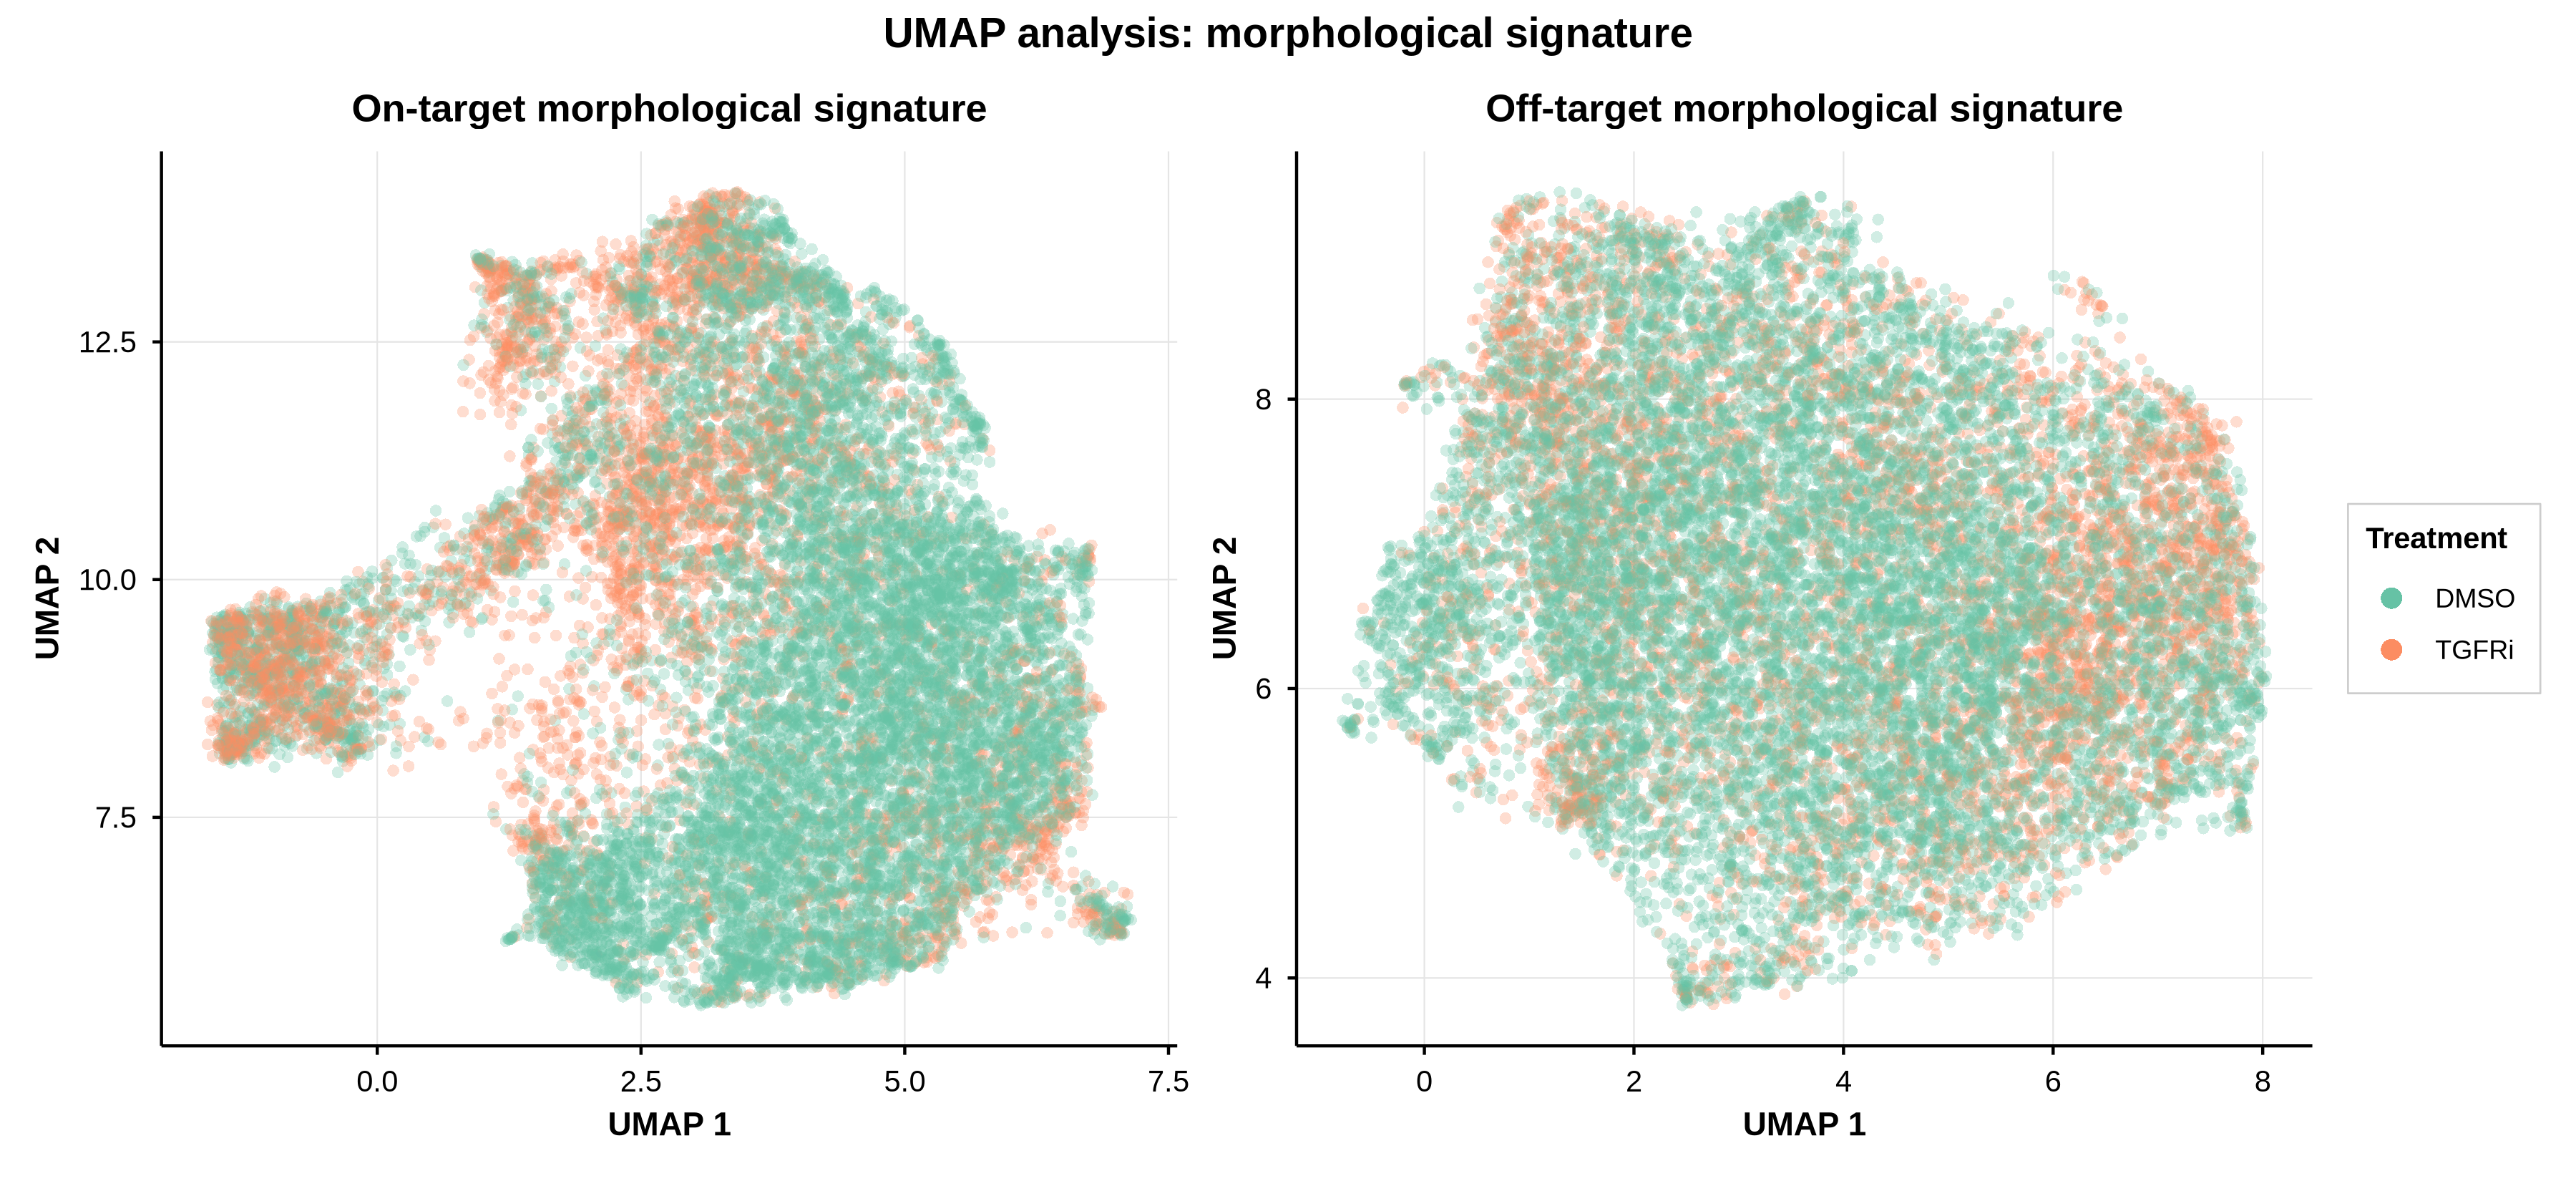

In [12]:
# Create on-target UMAP plot
plot_umap_on <- ggplot(umap_on_df, aes(x = UMAP1, y = UMAP2, color = Metadata_treatment)) +
    geom_point(alpha = point_alpha, size = point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Treatment") +
    labs(
        title = "On-target morphological signature",
        x = "UMAP 1",
        y = "UMAP 2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size)))

# Create off-target UMAP plot
plot_umap_off <- ggplot(umap_off_df, aes(x = UMAP1, y = UMAP2, color = Metadata_treatment)) +
    geom_point(alpha = point_alpha, size = point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Treatment") +
    labs(
        title = "Off-target morphological signature",
        x = "UMAP 1",
        y = "UMAP 2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size)))

# Combine plots using patchwork
umap_combined <- plot_umap_on + plot_umap_off +
    plot_layout(guides = "collect") +
    plot_annotation(
        title = "UMAP analysis: morphological signature",
        theme = theme(plot.title = element_text(face = "bold", size = 14, hjust = 0.5))
    )

# Display plot
options(repr.plot.width = plot_width_combined, repr.plot.height = plot_height_combined, repr.plot.res = render_dpi)
print(umap_combined)

In [13]:
# Save UMAP overlay comparison
ggsave(
    filename = file.path(figures_dir, "umap_on_off_comparison.png"),
    plot = umap_combined,
    width = plot_width_combined,
    height = plot_height_combined,
    dpi = render_dpi,
    bg = "white"
)
cat("Saved UMAP overlay plots to:", figures_dir, "\n")

Saved UMAP overlay plots to: ./figures 


### UMAP visualization: faceted by treatment

Individual treatment groups displayed separately to examine within-group distributions.

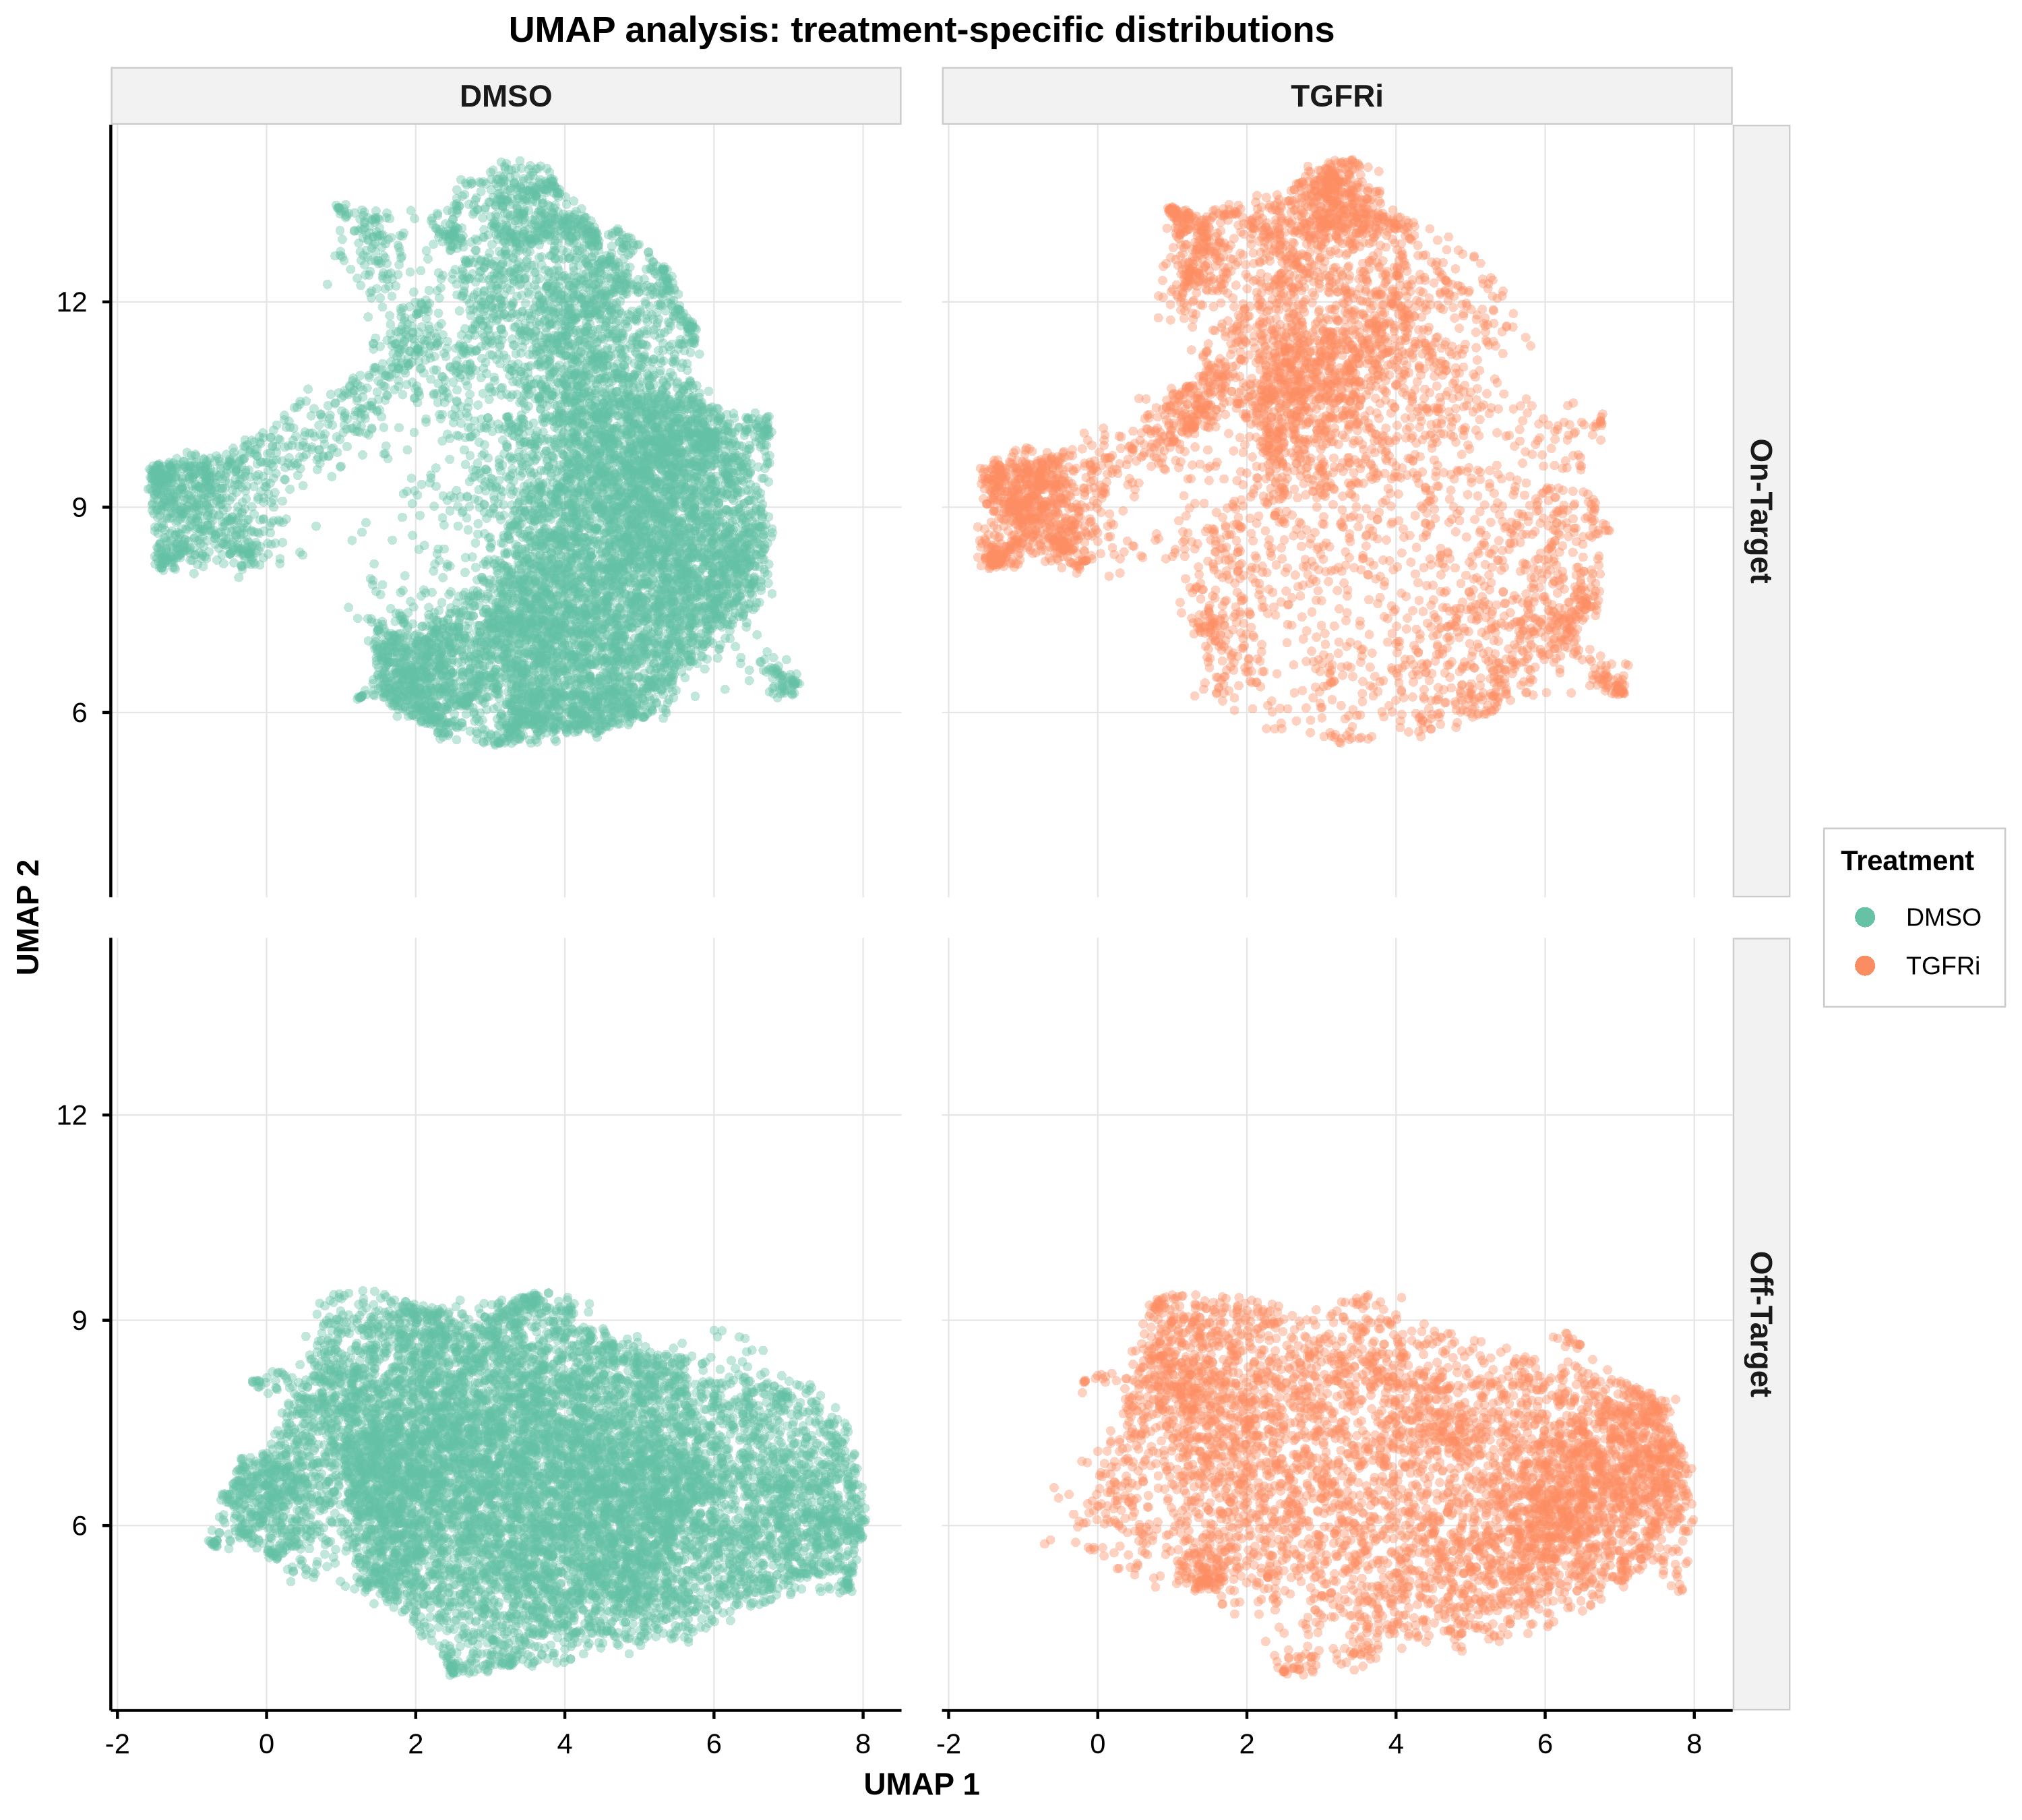

In [14]:
# Prepare data for faceting
umap_on_df_facet <- umap_on_df %>%
    mutate(signature_type = "On-Target")

umap_off_df_facet <- umap_off_df %>%
    mutate(signature_type = "Off-Target")

# Create faceted UMAP plot
umap_faceted <- bind_rows(umap_on_df_facet, umap_off_df_facet) %>%
    mutate(
        signature_type = factor(signature_type, levels = c("On-Target", "Off-Target")),
        Metadata_treatment = factor(Metadata_treatment, levels = c("DMSO", "TGFRi"))
    ) %>%
    ggplot(aes(x = UMAP1, y = UMAP2, color = Metadata_treatment)) +
    geom_point(alpha = facet_point_alpha, size = facet_point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Treatment") +
    facet_grid(signature_type ~ Metadata_treatment) +
    labs(
        title = "UMAP analysis: treatment-specific distributions",
        x = "UMAP 1",
        y = "UMAP 2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size))) +
    theme(
        strip.text = element_text(face = "bold", size = 11),
        panel.spacing = unit(1, "lines")
    )

# Display plot
options(repr.plot.width = plot_width_faceted, repr.plot.height = plot_height_faceted, repr.plot.res = render_dpi)
print(umap_faceted)

In [15]:
# Save UMAP faceted plot
ggsave(
    filename = file.path(figures_dir, "umap_facet_grid.png"),
    plot = umap_faceted,
    width = plot_width_faceted,
    height = plot_height_faceted,
    dpi = render_dpi,
    bg = "white"
)

cat("Saved UMAP faceted plots to:", figures_dir, "\n")

Saved UMAP faceted plots to: ./figures 
